## LDA 3

# Fitting an LDA to our corpus

We plan to perform topic modeling using *Latent Dirichlet Allocation* (abbreviated as LDA). An LDA is a *generative model* that learns a group of categories (or *topics*) for words that occur together in a corpus of documents. For a technical presentation of LDAs, see [Appendix A](404).

Let's start loading up our corpus:

In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rcParams['figure.dpi'] = 100

In [2]:
from utils.corpus import Corpus

corpus = Corpus(registry_path = 'utils/article_registry.json')

We instantiate an initial `Model` object and give it access to our corpus. We must also give it the number of topics it should train on.

In [3]:
from utils.model import Model

n_topics = 50
corpus.documents = corpus.documents
base_model = Model(corpus, n_topics)

Loading corpus. Num. of articles: 877


To train the `Model`, we can use the `train()` method. 

In [4]:
base_model.train(dtm=False)

Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...


We can save this model to a file using the `save()` method:

In [5]:
base_model.save()

Saved to: gensim_models/gensim_50/yLDA_gensim_50


# Visualizing the model

In [6]:
import numpy as np

<AxesSubplot:>

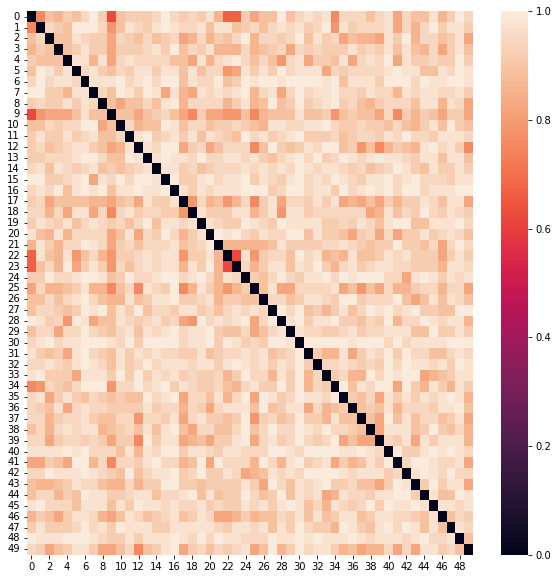

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(base_model.get_difference_matrix())

## Analyzing the Model Coherence

Coherence is an important statistic to compute in order to calibrate how many topics should we have on our final model. We can compute coherence by calling the `get_coherence()` method.

In [7]:
base_model.get_coherence()

0.42357956737884733

This coherence score allows us to do a search for the "best" `n_topics`. Notice that this coherence score is sensitive to the random number generation that is used when creating the `lda`. If we wanted to control this randomness, we can pass a `seed` parameter to the `train()` method. We will do this later when we implement our final model.

## Running a more complete grid-search

The last section shows we can compare different models and calibrate an optimal number of topics by training several models on a given number of topics. Now we will implement this experiment using a `gridsearch()` function. This function also makes use of the `get_stats()` method we included for each model.

TODO: Run it again after addressing this comment: https://github.com/RaRe-Technologies/gensim/issues/2115#issuecomment-443113360

In [4]:
def gridsearch(min_topics, max_topics, step, iterations=3, verbose=True):
    """
    Computes an array where we store statistics for each model. We run a search
    n number of times per number of topics and record a set of statistics for each model.
    At the end we will have n models per number of topics to compare.

    Returns an array of the following form:

    experiment = {
        n_topics: {
            0: [model(n_topics = 0).get_stats * iterations],
            1: [model(n_topics = 1).get_stats * iterations],
            ...
            iterations - 1: [model(n_topics = iterations - 1).get_stats()]
        }
    }
    
    We expect all these inner model_stats() to be slightly different
    due to stochasticity in the models.

    TODO: Should we save results at each step to allow resuming?
    """
    
    experiment = {}
    for n_topics in range(min_topics, max_topics, step):
        experiment[n_topics] = {}
        print(f"\nRunning experiment for {n_topics} topics.")
        print("----------")
        for i in range(iterations):
            if verbose:
                print(f"Iteration: {i}")

            experiment[n_topics][i] = Model(corpus, n_topics).get_stats()

    return experiment

**Careful:** this gridsearch can take a whole evening.

In [5]:
experiment = gridsearch(50, 160, 10, iterations=5)


Running experiment for 50 topics.
----------
Iteration: 0
Loading corpus. Num. of articles: 877
Timing training...
Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...
Getting model coherence...
Iteration: 1
Loading corpus. Num. of articles: 877
Timing training...
Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...
Getting model coherence...
Iteration: 2
Loading corpus. Num. of articles: 877
Timing training...
Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...
Getting model coherence...
Iteration: 3
Loading corpus. Num. of articles: 877
Timing training...
Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...
Getting model coherence...
Iteration: 4
Loading corpus. Num. of articles: 877
Timing training...
Bags of words collected. Starting training...
Static model trained!
Creating Topic objects...
Getting model coherence...

## Understanding the gridsearch results 

In [6]:
data = []
for n_topics in experiment:
    for iteration, results in experiment[n_topics].items():
        results['n_topics'] = n_topics
        results['iteration'] = iteration
        data.append(results)

df = pd.DataFrame(data)
df['time_lda_mins'] = df['time_lda'] / 60
df['time_coherence_mins'] = df['time_coherence'] / 60

In [7]:
df.to_json('../data/gridsearch.json')

In [16]:
df = pd.read_json('../data/gridsearch.json')

In [8]:
df.groupby('n_topics').mean()

,coherence,log_perplexity,time_lda,time_coherence,orphans,empty_topics,avg_arts_per_topic,std_arts_per_topic,min_arts_in_topic,max_arts_in_topic,diff_norm_score,diff_eig_score,topic_mass_length,iteration,time_lda_mins,time_coherence_mins
n_topics,,,,,,,,,,,,,,,,
50,0.385890,-8.286818,96.696241,65.653643,0.0,0.6,106.072000,78.406080,4.2,308.0,0.935612,0.925355,419.988000,2.0,1.611604,1.094227
60,0.389694,-8.327188,104.860567,74.532128,0.0,2.0,92.753333,78.757752,0.0,356.2,0.941574,0.932855,596.496667,2.0,1.747676,1.242202
70,0.390679,-8.420895,154.419103,90.345258,0.0,2.2,84.917143,74.764458,0.0,360.2,0.944580,0.937020,591.200000,2.0,2.573652,1.505754
80,0.386797,-8.503872,219.433239,95.552430,0.0,6.6,77.467500,77.159509,0.0,421.0,0.939812,0.932885,1063.552500,2.0,3.657221,1.592540
90,0.405703,-8.577005,289.800951,109.857614,0.0,5.6,71.915556,75.530243,0.0,430.2,0.947627,0.941483,887.562222,2.0,4.830016,1.830960
100,0.398360,-8.651184,193.015367,112.640017,0.0,12.0,64.788000,78.060909,0.0,460.2,0.942671,0.936704,1476.086000,2.0,3.216923,1.877334
110,0.396293,-8.826858,193.858801,119.784452,0.0,15.6,60.467273,71.791987,0.0,429.4,0.940857,0.935327,1598.863636,2.0,3.230980,1.996408
120,0.396700,-8.925297,194.213992,129.560500,0.0,19.0,57.450000,75.184119,0.0,499.6,0.938957,0.933536,1766.685000,2.0,3.236900,2.159342
130,0.400297,-9.071561,211.474841,141.655626,0.0,17.2,53.664615,71.603872,0.0,485.0,0.945995,0.941136,1487.770769,2.0,3.524581,2.360927


In [9]:
df[df['n_topics'] == 110]

,coherence,log_perplexity,time_lda,time_coherence,orphans,empty_topics,avg_arts_per_topic,std_arts_per_topic,min_arts_in_topic,max_arts_in_topic,diff_norm_score,diff_eig_score,topic_mass_length,n_topics,iteration,time_lda_mins,time_coherence_mins
30,0.405735,-8.768669,189.559458,129.203031,0,11,59.618182,77.085429,0,448,0.951388,0.946113,1168.790909,110,0,3.159324,2.153384
31,0.390150,-8.957822,199.228815,114.299693,0,13,62.127273,63.156963,0,327,0.940137,0.934689,1386.254545,110,1,3.320480,1.904995
32,0.402690,-8.738501,195.015467,123.187938,0,14,59.390909,74.340261,0,575,0.944878,0.939497,1449.381818,110,2,3.250258,2.053132
33,0.392478,-8.802324,192.748789,112.969993,0,23,60.454545,75.967892,0,400,0.929057,0.923008,2251.145455,110,3,3.212480,1.882833
34,0.390413,-8.866972,192.741475,119.261606,0,17,60.745455,68.409387,0,397,0.938823,0.933326,1738.745455,110,4,3.212358,1.987693


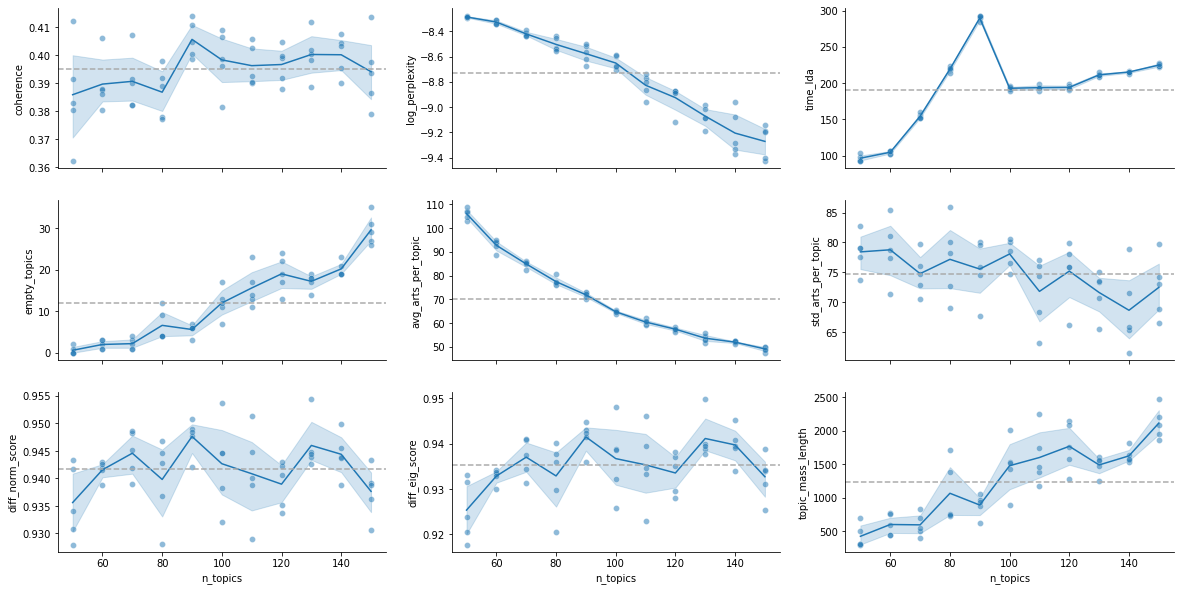

In [10]:
vars = ['coherence', 
        'log_perplexity', 
        'time_lda', 
        'empty_topics', 
        'avg_arts_per_topic', 
        'std_arts_per_topic', 
        'diff_norm_score',
        'diff_eig_score',
        'topic_mass_length']

rows = 3
cols = 3
fig, axs = plt.subplots(rows, cols, sharex=True)

for i, var in enumerate(vars):    
    col = i % cols
    row = i//3 % rows
    sns.lineplot(data=df, x='n_topics', y=var, ax=axs[row, col])
    sns.scatterplot(data=df, x='n_topics', y=var, ax=axs[row, col], alpha = 0.5)
    axs[row, col].axhline(df[var].mean(), linestyle='--', color='#aaa')
    sns.despine()

fig.set_figheight(10)
fig.set_figwidth(20)

# Picking a topic number

After reading online, people recommend that we save our dictionary in order to prevent randomness in it in the future. I will also set up the seed for the LDA.

It has been 47,984 days since Wittgetstein was born (as of today, 09/09/20).

In [6]:
final_model = Model(corpus, 90)
final_model.train(seed = 47984)
final_model.save()

Loading corpus. Num. of articles: 877
Bags of words collected. Starting training...
Static model trained!
1950 - 1954: 39
1955 - 1959: 0
1960 - 1964: 24
1965 - 1969: 8
1970 - 1974: 37
1975 - 1979: 16
1980 - 1984: 33
1985 - 1989: 61
1990 - 1994: 38
1995 - 1999: 70
2000 - 2004: 70
2005 - 2009: 75
2010 - 2014: 129
2015 - 2019: 211
2020 - 2024: 66
Sequential model trained!
Creating Topic objects...
Saved to: gensim_models/gensim_90/LDA_gensim_90


In [ ]:
print(final_model.get_stats())